### Forex rates prediction using ARIMA
##### 112103099 Omkar Oak - DSAI induction challenge

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import time
import datetime as dt

from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from fastprogress import progress_bar

import warnings
warnings.filterwarnings("ignore")

In [7]:
# importing the data
df = pd.read_csv("ForEx Rates 2006.csv")
print("Shape is: " , df.shape)
df.sample(5)

Shape is:  (4630, 36)


,Date,USD,AUS,CAN,SWF,DKK,EUR,GBP,HKD,IDR,...,ISK,MXN,PHP,PKR,PLN,RUB,SAR,TRY,VEF,BHD
2097,2015-09-16,66.219,47.661,50.274,68.182,10.0208,71.455,101.124,8.5439,0.005120,...,0.5201,4.0007,1.4200,0.6474,17.79,1.0104,17.66,22.08,NaN,175.5410
4071,2008-02-21,39.840,36.615,39.395,36.566,7.9158,68.397,78.838,5.1086,0.491400,...,NaN,3.6871,NaN,0.5288,16.53,1.6276,10.62,32.98,NaN,105.8420
1479,2018-01-29,63.600,51.481,51.546,67.840,10.5808,76.198,89.514,8.1352,0.004871,...,0.6310,3.4171,1.2403,0.5029,19.00,1.1294,16.96,16.77,NaN,168.7765
1023,2019-10-29,70.890,48.652,54.152,71.294,10.5420,77.851,91.187,9.0414,0.005320,...,0.5695,3.7052,1.3884,0.4510,18.44,1.1078,18.90,12.35,NaN,187.9860
1089,2019-07-29,68.755,47.444,52.222,69.325,10.2609,76.810,83.992,8.7889,0.004719,...,0.5648,3.6044,1.3475,0.4516,17.86,1.0833,18.33,12.23,NaN,182.2830


### Exploratory data analysis

In [8]:
print("Number of records:", len(df))
print(f"Number of days between {date(2006, 1, 1)} and {date(2023, 8, 31)}: {(date(2023, 8, 31) - date(2006, 1, 1)).days}")
print(f'Percentage Data available: {round(100*len(df)/((date(2023, 8, 31) - date(2006, 1, 1)).days), 2)}')

Number of records: 4630
Number of days between 2006-01-01 and 2023-08-31: 6451
Percentage Data available: 71.77


In [9]:
empty_cols = [col for col in df.columns if 100*df[col].isnull().sum()/len(df) > 1]
print(100*df[empty_cols].isnull().sum()/len(df))

IDR     7.948164
KRW     9.805616
ILS    22.375810
ISK    22.375810
PHP    22.375810
PKR     6.846652
VEF    99.568035
dtype: float64


- As there are a lot of null values in `VEF`, drop that column
- For other columns, we can interpolate the data using `linear` interpolation

In [10]:
df2 = df.drop(['VEF'],axis=1)
df2 = df2.interpolate(method='linear')

In [11]:
df2.isnull().sum()

Date    0
USD     0
AUS     0
CAN     0
SWF     0
DKK     0
EUR     0
GBP     0
HKD     0
IDR     0
JPY     0
KRW     0
MYR     0
NOK     0
NZD     0
SEK     0
SGD     0
THB     0
TWD     0
ZAR     0
AED     0
ARS     0
BRL     0
CNY     0
HUF     0
ILS     0
ISK     0
MXN     0
PHP     0
PKR     0
PLN     0
RUB     0
SAR     0
TRY     0
BHD     0
dtype: int64

#### converting date into `datetime` format

In [12]:
df2 = df2.sort_values('Date')
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.set_index('Date')
df2.head()

,USD,AUS,CAN,SWF,DKK,EUR,GBP,HKD,IDR,JPY,...,ILS,ISK,MXN,PHP,PKR,PLN,RUB,SAR,TRY,BHD
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-02,45.075,33.047,38.659,34.303,7.1437,54.2595,77.160,5.8131,0.4759,0.3679,...,12.34,0.3777,4.2359,1.0137,0.5587,13.80,1.5683,12.02,33.36,119.5655
2006-01-03,44.965,33.272,38.899,34.828,7.2410,54.5100,77.340,5.7992,0.4759,0.3679,...,12.34,0.3777,4.2279,1.0137,0.5587,14.12,1.5645,11.99,33.48,119.2915
2006-01-04,44.705,33.394,38.915,35.014,7.2613,54.5800,77.555,5.7604,0.4759,0.3678,...,12.34,0.3777,4.2256,1.0137,0.5587,14.23,1.5554,11.92,33.52,118.4985
2006-01-05,44.600,33.332,38.374,34.945,7.2347,54.5575,77.651,5.7520,0.4759,0.3639,...,12.34,0.3777,4.1957,1.0137,0.5587,14.17,1.5556,11.89,33.42,118.3225
2006-01-06,44.320,33.424,38.031,34.894,7.2225,54.4590,77.743,5.7162,0.4759,0.3625,...,12.34,0.3777,4.1964,1.0137,0.5587,14.15,1.5459,11.82,33.35,117.5830


<Axes: xlabel='Date'>

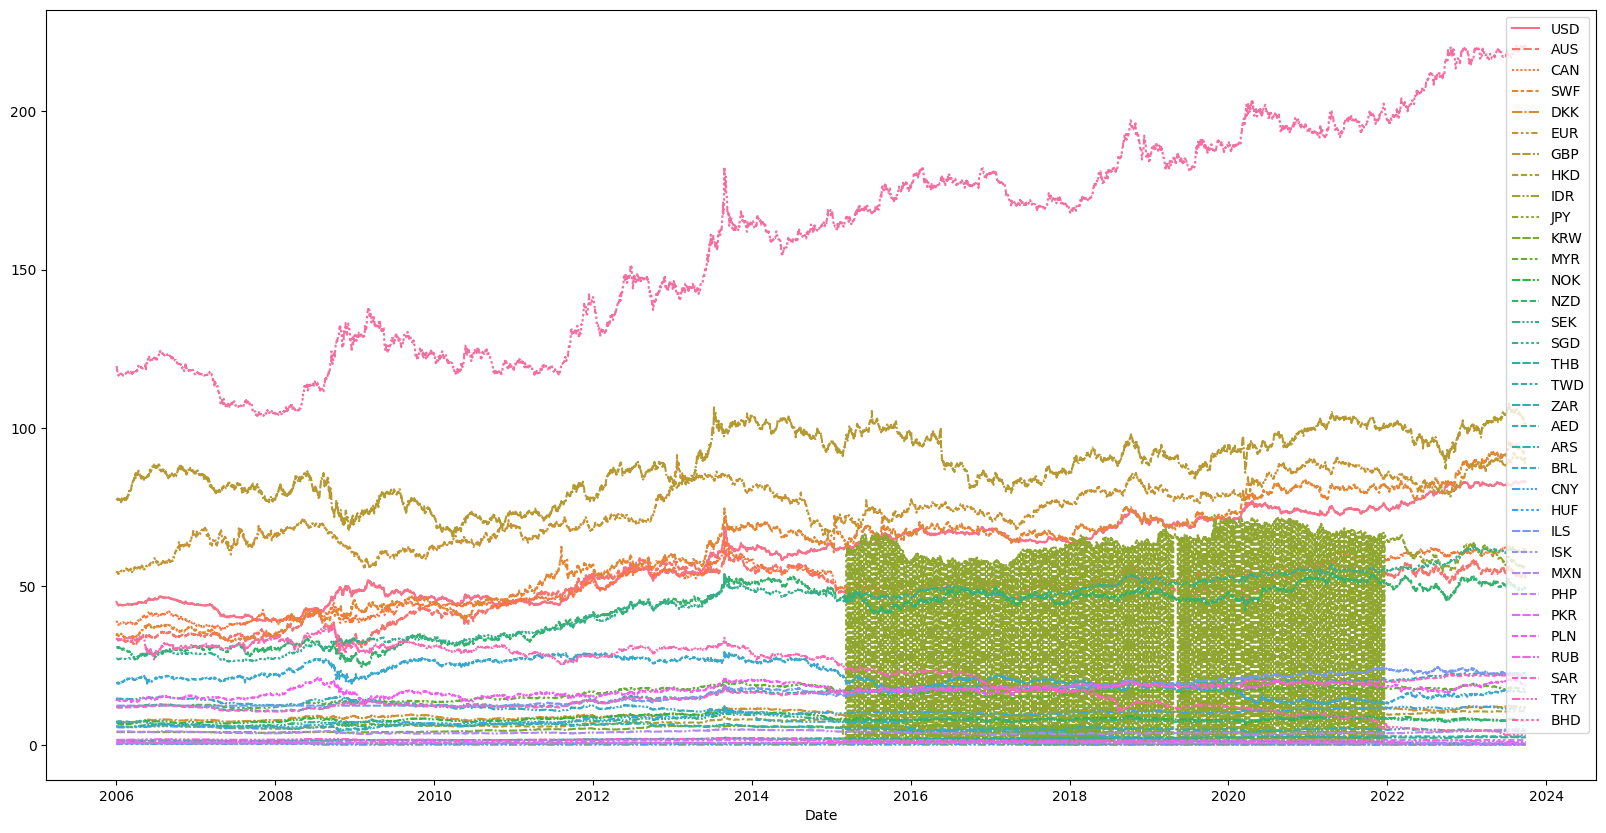

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
sns.lineplot(df2[:])

#### Consider only `USD` feature

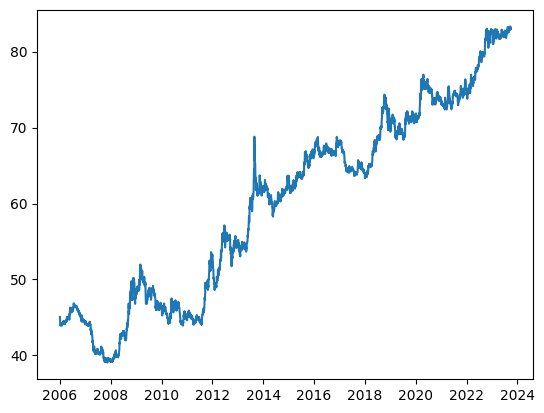

In [14]:
df = pd.DataFrame(df2['USD'])
plt.plot(df)

In [15]:
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)
ad_test(df)

1. ADF :  -0.10470351719677612
2. P-Value :  0.9489680250876702
3. Num Of Lags :  5
4. Num Of Observations Used For ADF Regression: 4624
5. Critical Values :
	 1% :  -3.431764994356697
	 5% :  -2.8621652633066823
	 10% :  -2.5671028303379537


- As the P-value = 0.94 , which is very high, the data is `non-stationary`
#### So, converting to stationary
- creates a new column called `diff` in the DataFrame df
- It calculates the difference between consecutive values in the `USD` column using the `diff()` method. 
- The fillna(0) part fills any NaN values resulting from the differencing operation with zeros.

1. ADF :  -28.820858667923822
2. P-Value :  0.0
3. Num Of Lags :  4
4. Num Of Observations Used For ADF Regression: 4625
5. Critical Values :
	 1% :  -3.4317646882419144
	 5% :  -2.8621651280716343
	 10% :  -2.567102758346238


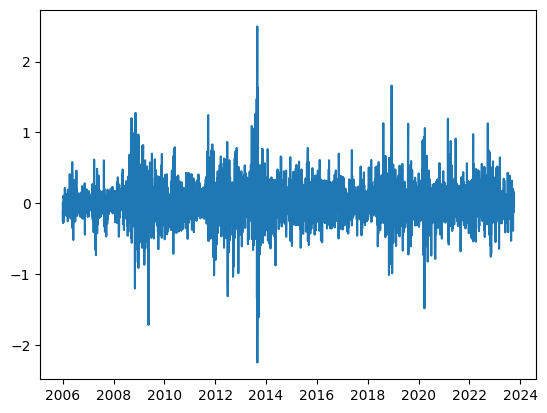

In [16]:
df['diff'] = df['USD'].diff().fillna(0)
ad_test(df['diff'])         #running ad test on diff column
plt.plot(df['diff'])
plt.show()

In [17]:
df.head(10)

,USD,diff
Date,,
2006-01-02,45.075,0.000
2006-01-03,44.965,-0.110
2006-01-04,44.705,-0.260
2006-01-05,44.600,-0.105
2006-01-06,44.320,-0.280
2006-01-09,44.250,-0.070
2006-01-10,44.185,-0.065
2006-01-11,43.915,-0.270
2006-01-12,44.020,0.105


- Now, we can see that `diff` column is stationary as p-value = `0.0`
##### Plotting the autocorrelation for `USD` and `diff` columns

<Figure size 640x480 with 0 Axes>

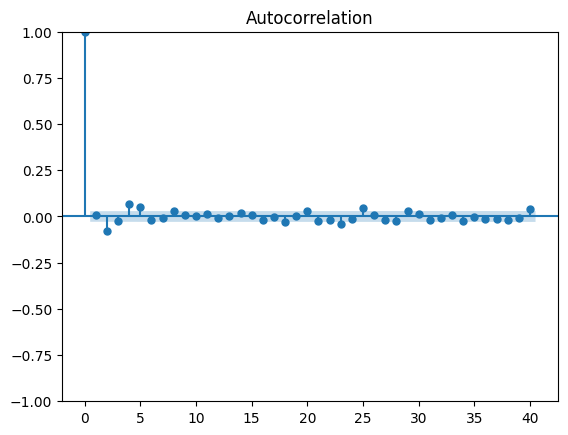

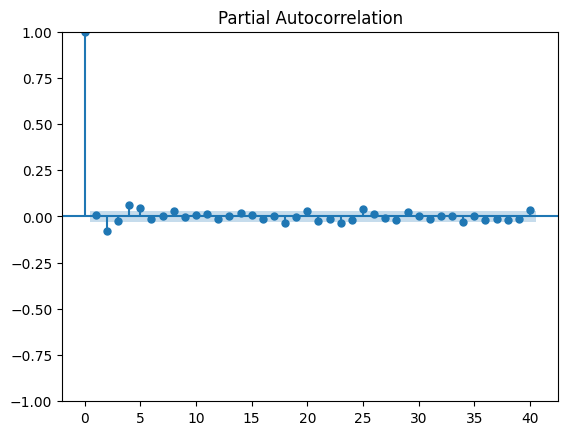

In [18]:
fig = plt.figure()
plot_acf(df['diff'].dropna(),lags=40)
plot_pacf(df['diff'].dropna(),lags=40)
plt.show()

- Stationary after differencing : d = 1
- Spike in PACF at 2, So, AR : p = 2
- Spike in ACF at 2, So,  MA : q = 2
- Thus taking order `(2,1,2)`

- Now, using auto_arima to find out the best order
- we get `(5,0,5)`

In [19]:
#from pmdarima import auto_arima
#stepwise_fit  = auto_arima(df ['diff'], traces=True, suppress_warnings=True, max_p=8,max_q=8)
#stepwise_fit.summary()

In [20]:
df['diff'].shape

(4630,)

In [21]:
#X_train = df['diff'].iloc[0:4600]
#X_test = df['diff'].iloc[4600:]
#X_train = pd.DataFrame(X_train,columns=['diff'])
#X_train.head()
#X_test = pd.DataFrame(X_test,columns=['diff'])
#X_test.head()

#### So, making 2 models to compare accuracy
1. model 1 of order (2,1,2)
2. model 2 of order (5,0,5)

In [22]:
from statsmodels.tsa.arima.model import ARIMA
model1=ARIMA(df['diff'],order=(2,1,2))
model1=model1.fit()
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                   diff   No. Observations:                 4630
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -299.448
Date:                Sun, 31 Dec 2023   AIC                            608.896
Time:                        09:59:53   BIC                            641.096
Sample:                    01-02-2006   HQIC                           620.226
                         - 09-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1365      0.113      1.205      0.228      -0.086       0.358
ar.L2         -0.0810      0.009     -9.088      0.000      -0.098      -0.064
ma.L1         -1.1270      0.114     -9.845      0.0

In [23]:
model2=ARIMA(df['diff'],order=(5,0,5))
model2=model2.fit()
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                   diff   No. Observations:                 4630
Model:                 ARIMA(5, 0, 5)   Log Likelihood                -274.543
Date:                Sun, 31 Dec 2023   AIC                            573.086
Time:                        10:00:00   BIC                            650.370
Sample:                    01-02-2006   HQIC                           600.279
                         - 09-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0080      0.004      1.869      0.062      -0.000       0.016
ar.L1          0.0925      0.108      0.858      0.391      -0.119       0.304
ar.L2         -0.4502      0.100     -4.524      0.0

#### Comparing both models visually

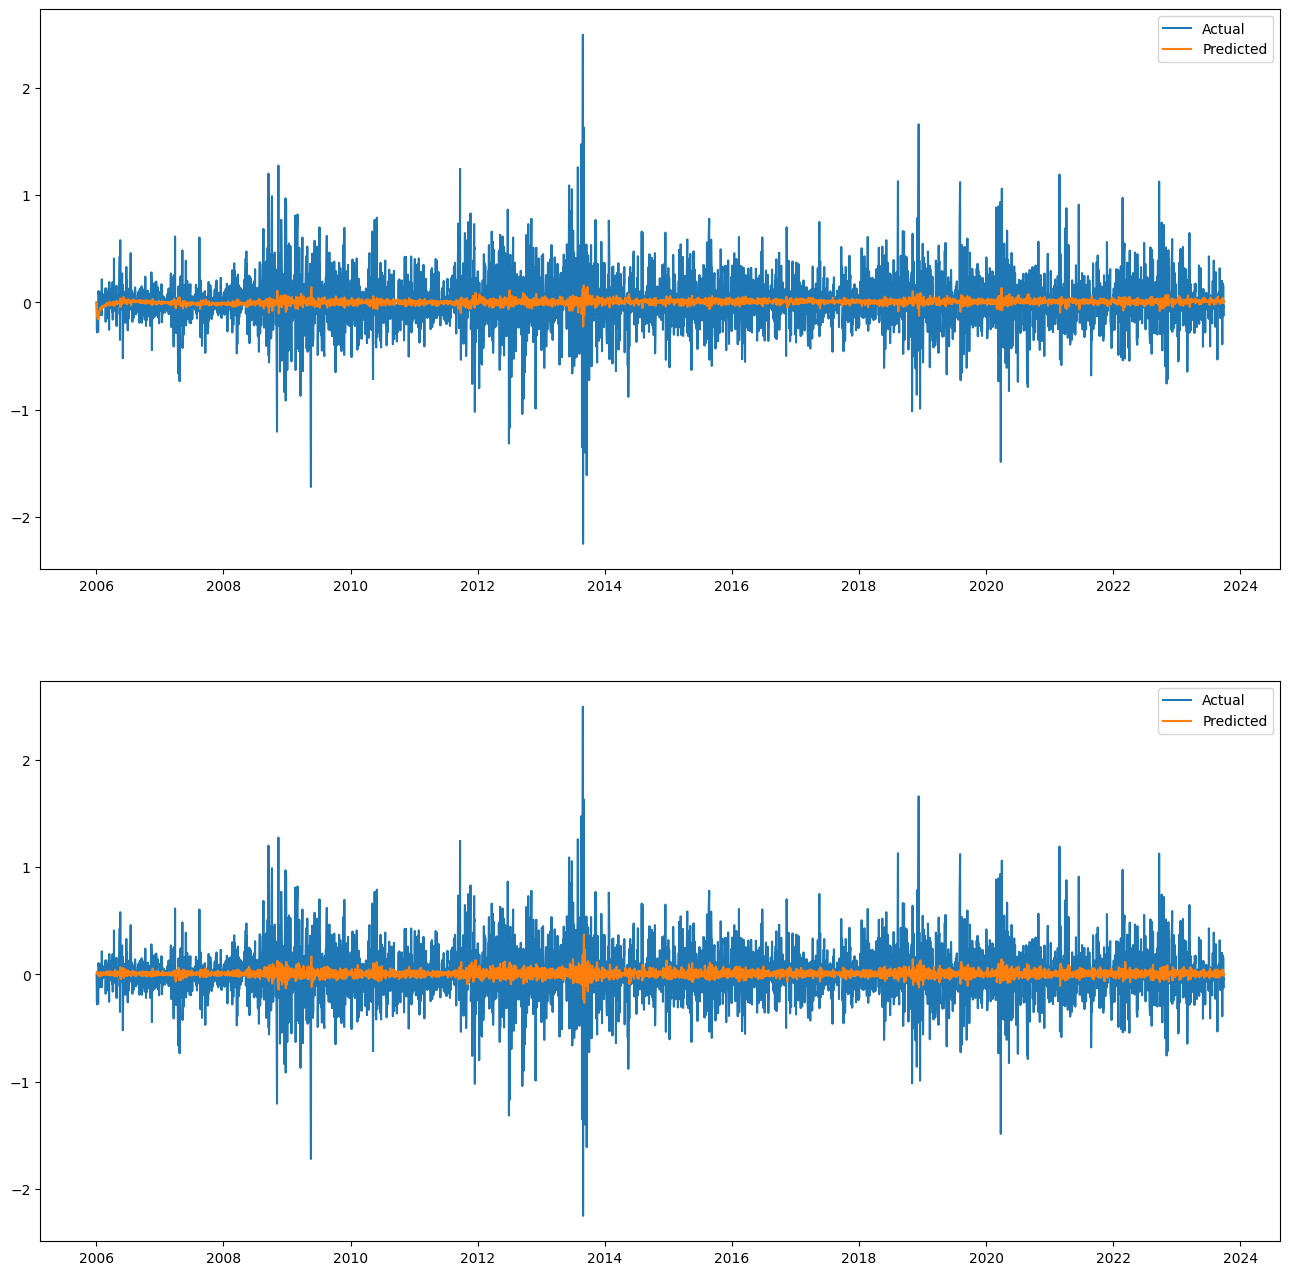

In [24]:
plt.figure(figsize=(16,16))
pred1 = model1.predict()
plt.subplot(2,1,1)
plt.plot(df['diff'], label="Actual")
plt.plot(pred1, label="Predicted")
plt.legend()

pred2 = model2.predict()
plt.subplot(2,1,2)
plt.plot(df['diff'], label="Actual")
plt.plot(pred2, label="Predicted")
plt.legend()

- We can see that `model 2` is much better than `model 1`
- Thus, henceforth using `model 2` only

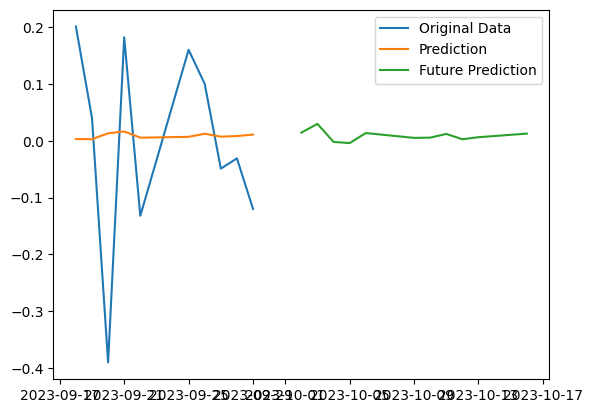

In [25]:
aug = model2.predict(start = len(df['diff']) - 10, end = len(df['diff']) - 1, dynamic=True)
pred_aug = model2.predict(start = len(df['diff']), end = len(df['diff']) + 10, dynamic=True)
plt.plot(df['diff'][len(df['diff']) - 10:], label = 'Original Data')
plt.plot(aug, label = 'Prediction')
plt.plot(pred_aug, label = 'Future Prediction')
plt.legend()
plt.show()

In [26]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,  
            'corr':corr})
forecast_accuracy(aug, df['diff'][len(df) - 10:])

{'mape': 1.0237261432808875,
 'me': 0.012521478388625495,
 'mae': 0.14082932012058308,
 'mpe': -1.0237261432808875,
 'rmse': 0.1738590767071379,
 'corr': -0.18244770450146242}

#### Making predictions for `USD` using `model 1 (2,1,2)`

In [27]:
size = int(len(df)*0.95) #0.67
train, test = df['USD'][0:size], df['USD'][size:len(df)]

print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in progress_bar(range(len(test))):
    
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()

    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
        
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

	 ARIMA MODEL : In- Sample Forecasting 



predicted = 81.370526, expected = 80.640000
predicted = 80.626835, expected = 80.505000
predicted = 80.551396, expected = 80.992000
predicted = 81.024726, expected = 81.091000
predicted = 81.033320, expected = 81.495000
predicted = 81.458879, expected = 81.540000
predicted = 81.529892, expected = 81.644000
predicted = 81.658412, expected = 81.728000
predicted = 81.728837, expected = 81.719000
predicted = 81.704356, expected = 81.633000
predicted = 81.629256, expected = 81.642000
predicted = 81.656304, expected = 81.713000


KeyboardInterrupt: 

In [ ]:
print(train.shape)
print(test.shape)
print(len(predictions))

(4398,)
(232,)
232


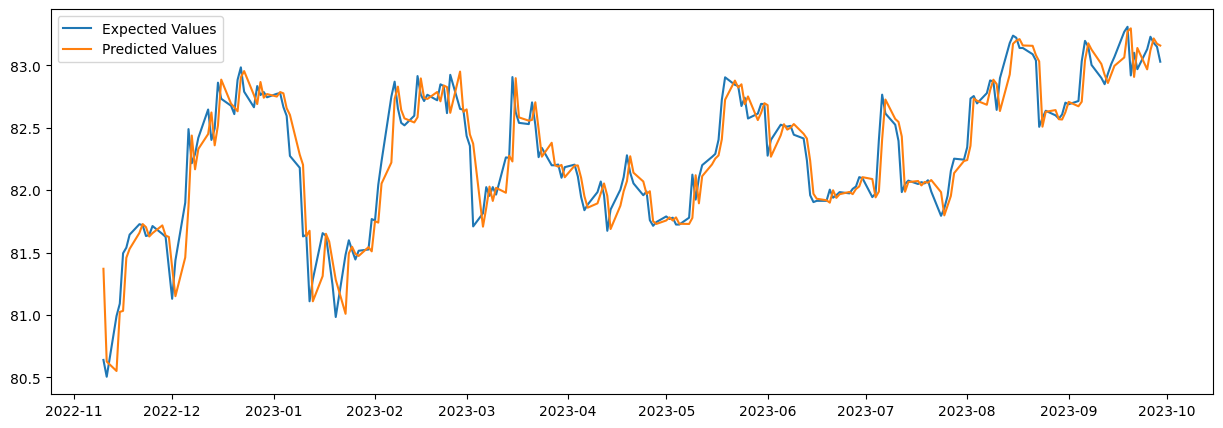

In [ ]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(df['USD'][size:len(df)],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values')
plt.legend(loc="upper left")
plt.show()

In [ ]:
forecast_accuracy(predictions_series, test)

{'mape': 0.0016407821517952143,
 'me': -0.007660746451986429,
 'mae': 0.13490508953987101,
 'mpe': -9.02325885334232e-05,
 'rmse': 0.19402258394008404,
 'corr': 0.9353793351603278}

#### Making predictions on `USD` using `model 2 (5,0,5)`
- using smaller test size, as this model takes longer time

In [ ]:
size = int(len(df)*0.99) #0.67
train, test = df['USD'][0:size], df['USD'][size:len(df)]

print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in progress_bar(range(len(test))):
    
    model = ARIMA(history, order=(5,0,5))
    model_fit = model.fit()

    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
        
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

	 ARIMA MODEL : In- Sample Forecasting 



predicted = 81.945595, expected = 82.155000
predicted = 82.130640, expected = 82.253000
predicted = 82.232446, expected = 82.245000
predicted = 82.239283, expected = 82.345000
predicted = 82.351613, expected = 82.735000
predicted = 82.741698, expected = 82.755000
predicted = 82.730938, expected = 82.696000
predicted = 82.691607, expected = 82.778000
predicted = 82.812909, expected = 82.880000
predicted = 82.898061, expected = 82.871000
predicted = 82.857258, expected = 82.644000
predicted = 82.650803, expected = 82.898000
predicted = 82.936454, expected = 83.180000
predicted = 83.173190, expected = 83.239000
predicted = 83.199647, expected = 83.222000
predicted = 83.221936, expected = 83.140000
predicted = 83.172239, expected = 83.140000
predicted = 83.154792, expected = 83.090000
predicted = 83.090846, expected = 83.040000
predicted = 83.049678, expected = 82.508000
predicted = 82.509888, expected = 82.580000
predicted = 82.612956, expected = 82.637000
predicted = 82.640702, expected 

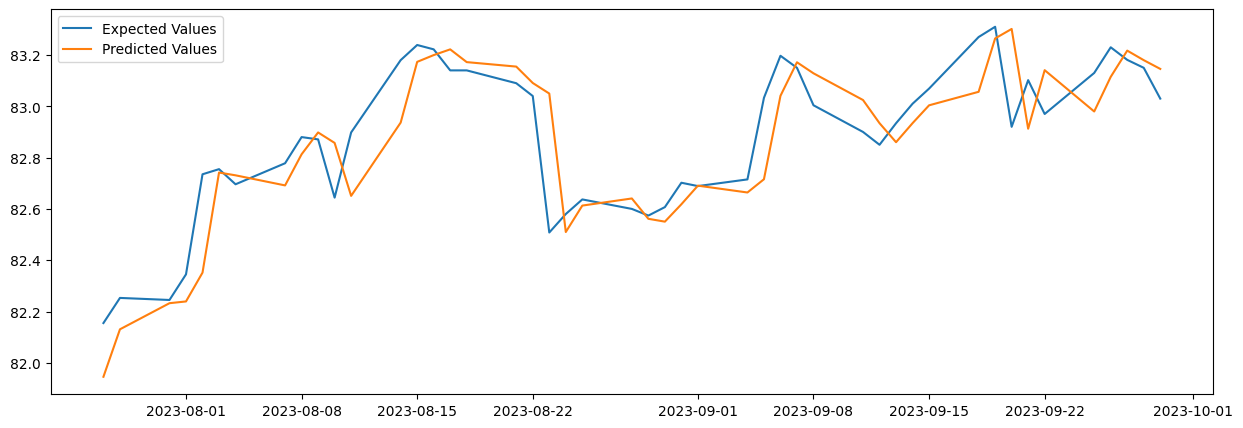

In [ ]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(df['USD'][size:len(df)],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values')
plt.legend(loc="upper left")
plt.show()

In [ ]:
forecast_accuracy(predictions_series, test)

{'mape': 0.0014013711964407445,
 'me': -0.023439234447719934,
 'mae': 0.11611760575861328,
 'mpe': -0.0002823296944422558,
 'rmse': 0.1610413922515317,
 'corr': 0.8684656965129222}

#### Now similarly, we can do the same predictions for other features of the dataset like `AUS, CAN, DKK` etc.